In [18]:
import os
import jieba
from tqdm import tqdm
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "True"


# 读取金庸小说语料，路径为小说 txt 文件夹
def load_corpus(corpus_dir):
    texts = []
    for file in os.listdir(corpus_dir):
        if file.endswith('.txt'):
            with open(os.path.join(corpus_dir, file), 'r', encoding='GB18030') as f:
                content = f.read()
                paragraphs = content.split('\n')
                for para in paragraphs:
                    para = para.strip()
                    if len(para) > 500:  # 去除太短的段落
                        tokens = list(jieba.cut(para))
                        texts.append(tokens)
    return texts

# 示例路径
corpus_dir = '/Users/lh/DL-nlp2025/HW2/jyxstxtqj_downcc'
texts = load_corpus(corpus_dir)
print(texts[0])


Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/83/ytqbvn616v5_nmwr5ckzpd_h0000gn/T/jieba.cache
Loading model cost 0.286 seconds.
Prefix dict has been built successfully.


['朱聪', '等', '都', '还', '了', '礼', '。', '柯镇恶', '却', '装作', '不知', '，', '冷冷的', '道', '：', '“', '江湖', '上', '的', '事', '，', '我', '兄弟', '再也', '没', '面目', '理会', '啦', '。', '我们', '在', '这里', '打鱼', '的', '打鱼', '，', '砍柴', '的', '砍柴', '，', '只要', '道长', '不要', '再', '来', '寻事', '，', '我们', '总', '可以', '安安稳稳', '的', '过', '这下', '半辈子', '。', '”', '丘处机', '给', '他', '一顿', '抢白', '，', '脸上', '微红', '，', '默不作声', '，', '僵', '了', '一阵', '，', '站', '起来', '道', '：', '“', '贫道', '这次', '坏', '了', '事', '，', '此后', '决', '不敢', '再', '踏进', '贵境', '。', '焦木大师', '的', '怨仇', '，', '着落', '在', '贫道', '身上', '，', '我必', '手刃', '奸徒', '，', '出', '这口', '恶气', '。', '现', '下', '贫道', '就此', '别', '过', '。', '”', '说', '着', '又', '是', '团团', '一揖', '，', '转身', '出外', '。', '柯镇恶', '喝道', '：', '“', '且慢', '！', '”', '丘处机', '转身', '道', '：', '“', '柯大哥', '有何', '吩咐', '？', '”', '柯镇恶', '道', '：', '“', '你', '把', '我们', '兄弟', '个个', '打', '得', '重伤', '，', '单凭', '这么', '一句', '话', '，', '就算', '了', '事', '吗', '？', '”', '丘处机', '道', '：', '“', '柯大哥', '意思', '怎样', '？', '贫道', '只要', '力所能及', '，', '无有', '不', '

In [ ]:
from gensim.models import Word2Vec

# 训练 Word2Vec 模型
w2v_model = Word2Vec(sentences=texts, vector_size=100, window=5, min_count=5, workers=4)
w2v_model.save("w2v_jinyong.model")


In [14]:
from gensim.models import Word2Vec
w2v_model = Word2Vec.load("w2v_jinyong.model")
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
all_words = [word for word in w2v_model.wv.index_to_key if len(word) >= 2]
# 获取模型中的所有
# 取前200个词（太多词可视化会乱）
words = all_words[:100]


# 获取词向量
word_vectors = [w2v_model.wv[word] for word in words]
import numpy as np

word_vectors = np.array([w2v_model.wv[word] for word in words])
# TSNE降维到二维
tsne = TSNE(n_components=2, random_state=42, perplexity=40)
word_vec_2d = tsne.fit_transform(word_vectors)


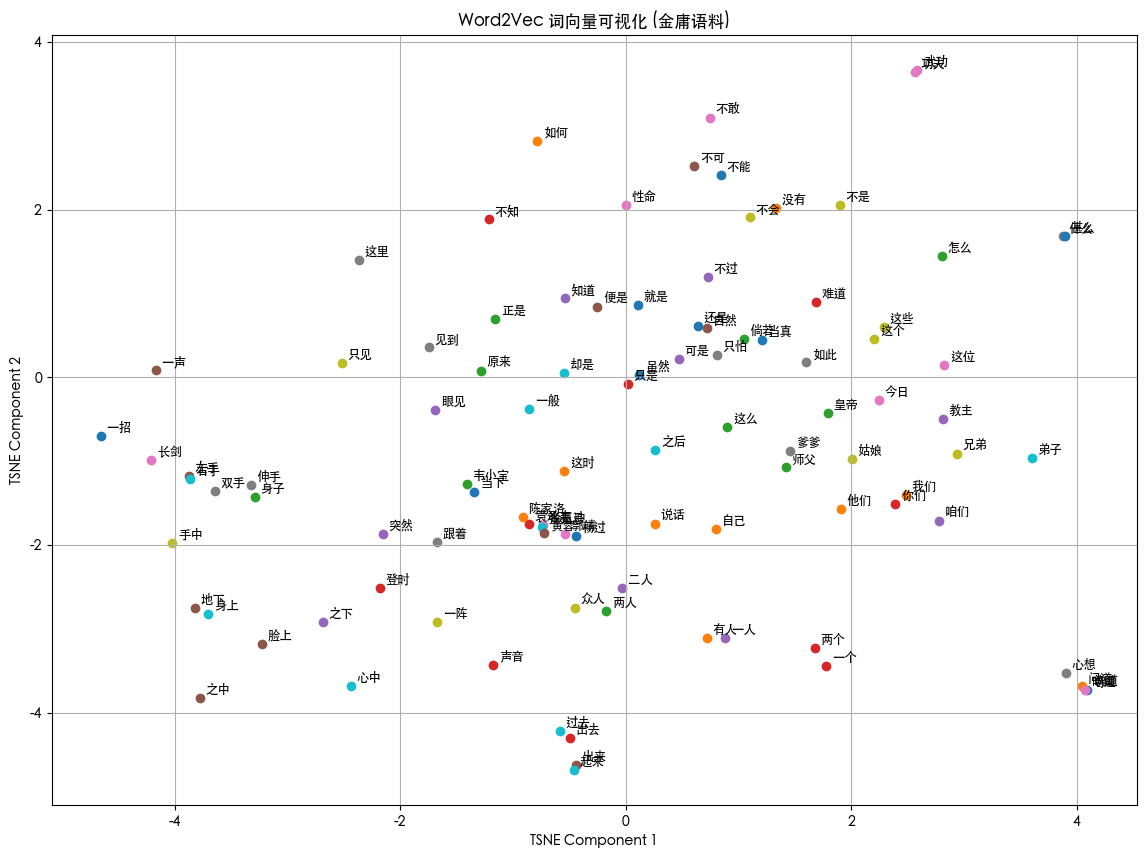

In [15]:
plt.figure(figsize=(14, 10))
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['Heiti TC']  # macOS 内建中文字体
plt.rcParams['axes.unicode_minus'] = False      # 解决负号显示问题


for i, word in enumerate(words):
    x, y = word_vec_2d[i]
    plt.scatter(x, y)
    plt.text(x + 0.05, y + 0.05, word, fontsize=9)
plt.title("Word2Vec 词向量可视化 (金庸语料)")
plt.xlabel("TSNE Component 1")
plt.ylabel("TSNE Component 2")
plt.grid(True)
plt.show()


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import jieba
from collections import Counter
import numpy as np
import tqdm
print('1')
# 1. 预处理语料
def tokenize(texts, unit='word'):
    if unit == 'char':
        return [list(text) for text in texts]
    else:
        return [list(jieba.cut(text)) for text in texts]

# 构建词表
def build_vocab(tokenized_texts, min_freq=5):
    counter = Counter()
    for tokens in tokenized_texts:
        counter.update(tokens)
    vocab = {'<PAD>': 0, '<UNK>': 1}
    for word, freq in counter.items():
        if freq >= min_freq:
            vocab[word] = len(vocab)
    return vocab

# 编码文本
def encode(texts, vocab):
    return [[vocab.get(w, vocab['<UNK>']) for w in tokens] for tokens in texts]

# Dataset
class NextTokenDataset(Dataset):
    def __init__(self, sequences, seq_len):
        self.samples = []
        for seq in sequences:
            for i in range(len(seq) - seq_len):
                input_seq = seq[i:i+seq_len]
                target = seq[i+seq_len]
                self.samples.append((input_seq, target))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        x, y = self.samples[idx]
        return torch.tensor(x), torch.tensor(y)

# 模型
class LSTM_LanguageModel(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, hidden_dim=128):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x):
        emb = self.embedding(x)
        out, _ = self.lstm(emb)
        logits = self.linear(out[:, -1, :])  # 只取最后一个位置预测
        return logits



1


In [ ]:
# 假设 texts 是金庸小说的列表（每本一本字符串）

# # 读取小说
# texts = []
# for path in glob("/Users/lh/DL-nlp2025/HW2/jyxstxtqj_downcc/*.txt"):
#     print(path)
#     with open(path, encoding='GB18030') as f:
#         texts.append(f.read())

print('1')
vocab = build_vocab(texts)
print(len(vocab))
sequences = encode(texts, vocab)

dataset = NextTokenDataset(sequences, 20)
dataloader = DataLoader(dataset, batch_size=256, shuffle=True)

model = LSTM_LanguageModel(len(vocab)).to('mps')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

for epoch in range(10):
    model.train()
    total_loss = 0
    for x, y in tqdm.tqdm(dataloader):
        logits = model(x.to('mps'))
        loss = criterion(logits, y.to('mps'))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1} | Loss: {total_loss:.4f}")
# 训练模型

# 保存 embedding
embedding_matrix = model.embedding.weight.detach().cpu().numpy()
np.save("lstm_word_embeddings.npy", embedding_matrix)


1
24610


 54%|█████▍    | 3974/7366 [01:02<00:52, 64.66it/s]